# Solving Navier-Stokes with a stationary body subject to a gust

In [1]:
using ViscousFlow

In [2]:
using Plots
pyplot()

LoadError: InitError: PyError (PyImport_ImportModule

The Python package matplotlib could not be imported by pyimport. Usually this means
that you did not install matplotlib in the Python version being used by PyCall.

PyCall is currently configured to use the Python version at:

/usr/bin/python3

and you should use whatever mechanism you usually use (apt-get, pip, conda,
etcetera) to install the Python package containing the matplotlib module.

One alternative is to re-configure PyCall to use a different Python
version on your system: set ENV["PYTHON"] to the path/name of the python
executable you want to use, run Pkg.build("PyCall"), and re-launch Julia.

Another alternative is to configure PyCall to use a Julia-specific Python
distribution via the Conda.jl package (which installs a private Anaconda
Python distribution), which has the advantage that packages can be installed
and kept up-to-date via Julia.  As explained in the PyCall documentation,
set ENV["PYTHON"]="", run Pkg.build("PyCall"), and re-launch Julia. Then,
To install the matplotlib module, you can use `pyimport_conda("matplotlib", PKG)`,
where PKG is the Anaconda package the contains the module matplotlib,
or alternatively you can use the Conda package directly (via
`using Conda` followed by `Conda.add` etcetera).

) <class 'ImportError'>
ImportError('\n\nIMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!\n\nImporting the numpy c-extensions failed.\n- Try uninstalling and reinstalling numpy.\n- If you have already done that, then:\n  1. Check that you expected to use Python3.7 from "/usr/bin/python3",\n     and that you have no directories in your PATH or PYTHONPATH that can\n     interfere with the Python and numpy version "1.17.4" you\'re trying to use.\n  2. If (1) looks fine, you can open a new issue at\n     https://github.com/numpy/numpy/issues.  Please include details on:\n     - how you installed Python\n     - how you installed numpy\n     - your operating system\n     - whether or not you have multiple versions of Python installed\n     - if you built from source, your compiler versions and ideally a build log\n\n- If you\'re working with a numpy git repository, try `git clean -xdf`\n  (removes all files not under version control) and rebuild numpy.\n\nNote: this error has many possible causes, so please don\'t comment on\nan existing issue about this - open a new one instead.\n\nOriginal error was: No module named \'numpy.core._multiarray_umath\'\n')
  File "/usr/lib/python3/dist-packages/matplotlib/__init__.py", line 138, in <module>
    from . import cbook, rcsetup
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 31, in <module>
    import numpy as np
  File "/usr/lib/python3/dist-packages/numpy/__init__.py", line 142, in <module>
    from . import core
  File "/usr/lib/python3/dist-packages/numpy/core/__init__.py", line 47, in <module>
    raise ImportError(msg)

during initialization of module PyPlot

Set the flow parameters

In [3]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set up the domain, grid spacing, and time step size

In [4]:
xlim = (-2.0,3.0)
ylim = (-1.0,1.0)

Δx, Δt = setstepsizes(Re)

(0.01, 0.005)

#### Set up points on the body. We set the points so that the spacing between them is 1.5 times the grid spacing.

Here is a plate:

In [5]:
body = Plate(1.0,1.5Δx)

Plate with 66 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


or here is a NACA 0012 airfoil

In [6]:
#body = NACA4(0.0,0.0,0.12,1.5Δx)

#### Transform the body to a specified initial position and orientation.

In [7]:
cent = (0.0,0.0)
α = 0π/180 #π/3 #π/4
T = RigidTransform(cent,-α)
T(body) # transform the body to the current configuration

Plate with 66 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): -0.0


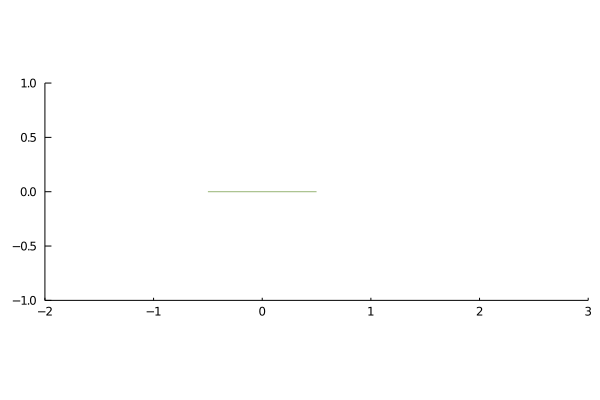

In [8]:
plot(body,xlim=xlim,ylim=ylim)

Collect the body point data into a vector

In [9]:
X = VectorData(collect(body));

### Now set up the system

Set up the system operators

In [10]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt,U∞ = U∞, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 504 x 208

Initial conditions, and grid coordinates

In [11]:
w₀ = Nodes(Dual,size(sys));
f = VectorData(X);

In [12]:
σx = 0.4
σy = 0.1
A = 5
x0 = -1.2
y0 = 0.0
gauss = SpatialGaussian(σx,σy,x0,y0,A)

gustx = EmptySpatialField()
gusty = gauss
gaussfield = GeneratedField(Edges(Primal,size(sys)),gustx,gusty,sys.grid);

t0 = 0.1
sigt = 0.1

pulse = PulseField(gaussfield,t0,sigt);

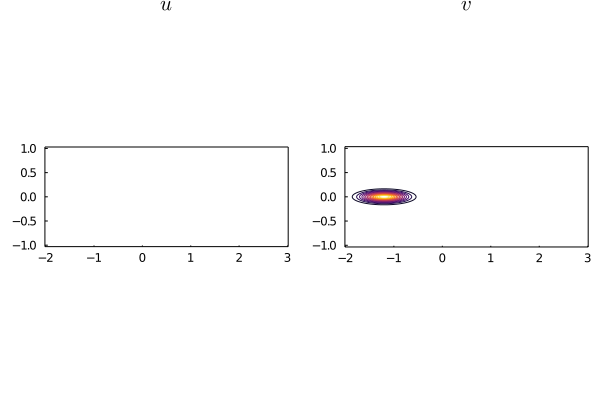

In [13]:
plot(gaussfield)

Set up the integrator here

In [14]:
plan_intfact(t,u) = CartesianGrids.plan_intfact(t,u,sys)
plan_constraints(u,t) = ConstrainedSystems.plan_constraints(u,t,sys)
r₁(u,t) = ConstrainedSystems.r₁(u,t,sys) + curl(pulse(t))
r₂(u,t) = ConstrainedSystems.r₂(u,t,sys)


@time solver = IFHERK(w₀,f,timestep(sys),plan_intfact,plan_constraints,(r₁,r₂),rk=ConstrainedSystems.RK31)

  9.301802 seconds (19.67 M allocations: 3.559 GiB, 8.20% gc time)


Order-3 IF-HERK integrator with
   State of type Nodes{Dual,504,208,Float64,Array{Float64,2}}
   Force of type VectorData{66,Float64,Array{Float64,1}}
   Time step size 0.005


Initialize the state vector and the history vectors

In [55]:
typeof(sys)
fields::pressurejump(f,body,sys)

LoadError: MethodError: no method matching *(::ScalarData{66,Float64,SubArray{Float64,1,Array{Float64,1},Tuple{UnitRange{Int64}},true}}, ::ScalarData{66,Float64,SubArray{Float64,1,Array{Float64,1},Tuple{UnitRange{Int64}},true}})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:538
  *(!Matched::PyCall.PyObject, ::Any) at /home/sinan/.julia/packages/PyCall/BcTLp/src/pyoperators.jl:13
  *(!Matched::ConstrainedSystems.IFOperator, ::Any) at /home/sinan/.julia/packages/ConstrainedSystems/pgefJ/src/timemarching/ifherk.jl:166
  ...

In [46]:
t = 0.0
u = zero(w₀)
# Rate at which to store field data
tsample = 0.2

# Field data storage plan
S = StorePlan(tsample,"state"=>u,"time"=>t)
data_history = initialize_storage(S)

# Force data storage plan, stored every time step

F = StorePlan(timestep(sys),"fx"=>sum(f.u),"fy"=>sum(f.v),"pressure"=>pressurejump(f,body,sys),"time"=>t)
#F = StorePlan(timestep(sys),"fx"=>sum(f.u),"fy"=>sum(f.v),"pressure"=>pressurejump(f,body,sys),"time"=>t)
force_history = initialize_storage(F)

nothing

LoadError: MethodError: no method matching *(::ScalarData{66,Float64,SubArray{Float64,1,Array{Float64,1},Tuple{UnitRange{Int64}},true}}, ::ScalarData{66,Float64,SubArray{Float64,1,Array{Float64,1},Tuple{UnitRange{Int64}},true}})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:538
  *(!Matched::PyCall.PyObject, ::Any) at /home/sinan/.julia/packages/PyCall/BcTLp/src/pyoperators.jl:13
  *(!Matched::ConstrainedSystems.IFOperator, ::Any) at /home/sinan/.julia/packages/ConstrainedSystems/pgefJ/src/timemarching/ifherk.jl:166
  ...

### Advance the system!

Set the length of time to integrate over.

In [16]:
tsim = 1.0;

In [17]:
for ti in timerange(tsim,sys)
    global t, u, f = solver(t,u)
    
    fds = force(f,sys) 
    
    store_data!(data_history,t,S,"state" => u, "time" => t)
    store_data!(force_history,t,F,"fx" => sum(fds.u),"fy" => sum(fds.v),"pressure" => pressurejump(fds,body,sys),"time" => t)
    
 end
println("solution completed through time t = ",t)

LoadError: MethodError: no method matching *(::ScalarData{66,Float64,SubArray{Float64,1,Array{Float64,1},Tuple{UnitRange{Int64}},true}}, ::ScalarData{66,Float64,SubArray{Float64,1,Array{Float64,1},Tuple{UnitRange{Int64}},true}})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:538
  *(!Matched::PyCall.PyObject, ::Any) at /home/sinan/.julia/packages/PyCall/BcTLp/src/pyoperators.jl:13
  *(!Matched::ConstrainedSystems.IFOperator, ::Any) at /home/sinan/.julia/packages/ConstrainedSystems/pgefJ/src/timemarching/ifherk.jl:166
  ...

In [18]:
force_history_amp5 = deepcopy(force_history)

LoadError: UndefVarError: force_history not defined

#### Plotting

Basic plot

In [19]:
plot(vorticity(data_history["state"][1],sys),sys,levels=range(-15,15,length=30), color = :RdBu,clim=(-15,15))
plot!(body)

LoadError: BoundsError: attempt to access 0-element Array{Nodes{Dual,504,208,Float64,Array{Float64,2}},1} at index [1]

In [20]:
data_history["time"][1]

LoadError: BoundsError: attempt to access 0-element Array{Float64,1} at index [1]

Streamlines

In [21]:
plot(streamfunction(data_history["state"][end],sys),sys,levels=range(-1,1,length=31), color = :black,clim=(-0.25,0.25),xlim=(-1,3),ylim=(-1,1))
plot!(body)

LoadError: BoundsError: attempt to access 0-element Array{Nodes{Dual,504,208,Float64,Array{Float64,2}},1} at index [0]

Plot lift and drag coefficient

In [22]:
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[1],force_history["time"],2*force_history["fy"],xlim=(0,6),ylim=(-4,4),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],force_history["time"],2*force_history["fx"],xlim=(0,6),ylim=(-4,4),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt

LoadError: UndefVarError: force_history not defined

In [23]:
plot(force_history["pressure"][1])
plot!(force_history["pressure"][21])
plot!(force_history["pressure"][50])
plot!(force_history["pressure"][75])
plot!(force_history["pressure"][100])

LoadError: UndefVarError: force_history not defined

In [24]:
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[1],force_history["time"],2*force_history["fy"],xlim=(0,6),ylim=(0,4),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],force_history["time"],2*force_history["fx"],xlim=(0,6),ylim=(0,4),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt

LoadError: UndefVarError: force_history not defined

In [25]:
plot(force_history_amp5["time"],2*force_history_amp5["fy"],xlim=(0,6),ylim=(-4,4),xlabel="Convective time",ylabel="\$C_L\$",label="A=5")
plot!(force_history_amp10["time"],2*force_history_amp10["fy"],label="A=10")

LoadError: UndefVarError: force_history_amp5 not defined